# Deep learning model

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score  
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

import wandb
os.environ["WANDB_SILENT"] = "True"

## Setup

### Specify device
Checkt ob eine GPU mit cuda kompatibilität verfügbar ist und spezifiziert entsprechend ob das Modell auf der CPU oder GPU ausgeführt werden soll.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Read in training dataframe

In einem ersten Schritt wird das Dataframe ins Notebook geladen. Dieses besitzt bereits eine zusätzliche Spalte, welche die Messwerte dem Zeitstempel nach auf 5-Sekunden-Abschnitte gruppiert. Zudem wurden die Sensordaten bereits pro Sensor zusammengefasst. Es bildet die Datengrundlage, aus welcher anschliessend ein Datensatz für das Training der Modelle gebildet wird. 

In [3]:
df = pd.read_csv("./data/deep_models.csv")
df.head()

,time,name,activity,acc,mag,gyr,ori,kmh,5s_index
0,2022-04-03 11:47:11.212,Raphi,Sitting,31.205772,5916.8509,90.032528,3.682111,0.0,39527230.0
1,2022-04-03 11:47:11.268,Raphi,Sitting,31.167446,5917.1620,89.882870,3.679749,0.0,39527230.0
2,2022-04-03 11:47:11.326,Raphi,Sitting,31.218333,5917.6195,90.149810,3.679155,0.0,39527230.0
3,2022-04-03 11:47:11.388,Raphi,Sitting,31.175130,5917.3328,90.282364,3.672559,0.0,39527230.0
4,2022-04-03 11:47:11.445,Raphi,Sitting,31.158147,5916.3507,90.185239,3.681543,0.0,39527230.0


## Eda & Preprocessing

### Visualize samples
Nachfolgend wird die erste 5-Sekunden-Gruppe visualisiert.

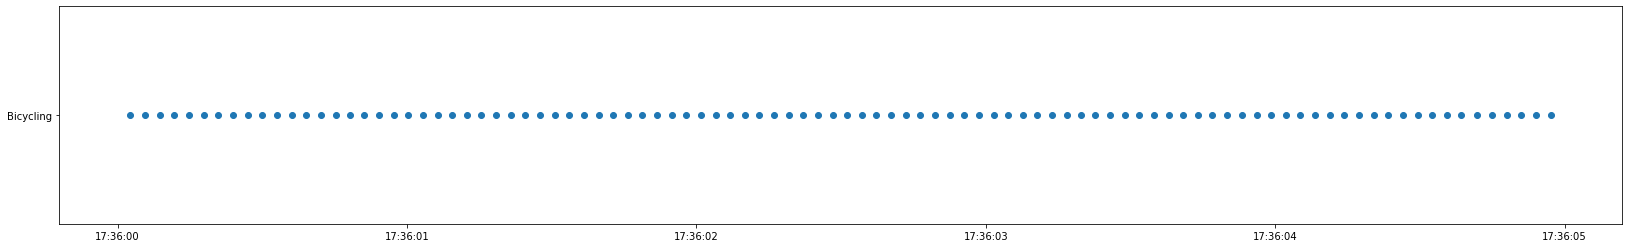

Nr of samples: 98


In [4]:
sample_1 = df.loc[df["5s_index"]==list(set(df["5s_index"]))[0]]

sample_1
sample_1["time"] = pd.to_datetime(sample_1["time"], format='%Y-%m-%d %H:%M:%S.%f')

plt.figure(figsize=(28,4))
plt.scatter(data=sample_1, x="time", y="activity")
plt.show()

print("Nr of samples:", len(sample_1))

Unser erstes Beispiel hat eine Länge von 98 Samples und alle Messwerte wurden auf derselben Aktivität aufgezeichnet. Das macht an sich Sinn, da wir aus der bisherigen Analyse im models.ipynb Notebook wissen, dass die meisten Messungen um 90 bis 100 Samples besitzen. Für unser CNN benötigen wir jedoch eine fixe Länge an Messpunkten, damit die Dimensionen der Tensoren einheitlich sind. Die einzelnen Sensoren besitzen ausserdem unterschiedliche Werteskalen. Diese möchten wir auch vor dem training standardisieren.

In [5]:
df.isna().sum(axis=1).value_counts()
df = df.dropna(axis="index")

### Normalize scales

In [6]:
x = df[["acc", "mag", "gyr", "ori", "kmh"]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_val = pd.DataFrame(x_scaled)
df[["acc", "mag", "gyr", "ori", "kmh"]] = df_val

array([[<AxesSubplot:title={'center':'acc'}>,
        <AxesSubplot:title={'center':'mag'}>],
       [<AxesSubplot:title={'center':'gyr'}>,
        <AxesSubplot:title={'center':'ori'}>],
       [<AxesSubplot:title={'center':'kmh'}>, <AxesSubplot:>]],
      dtype=object)

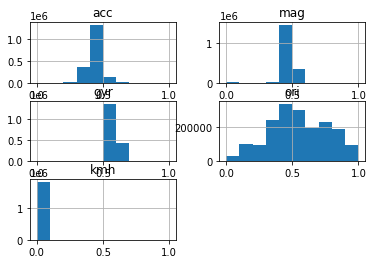

In [7]:
df[["acc", "mag", "gyr", "ori", "kmh"]].hist()

### Create ~5 sec samples

From the analysis from the non-deep learning model, we know that the sample size varies per 5 second time window. Because the CNN needs a fixed size in our setup, the length of the samples is set to 90 points of measures.

In [8]:
sample_length = 90

# cut upper boundary
df_fix_len = df.groupby("5s_index").head(sample_length)

# cut lower boundary
v = df_fix_len["5s_index"].value_counts()
df_fix_len = df_fix_len[df_fix_len["5s_index"].isin(v.index[v.ge(sample_length)])]

df_fix_len["5s_index"].value_counts()
df = df_fix_len

### Visualize the proportion of samples per class

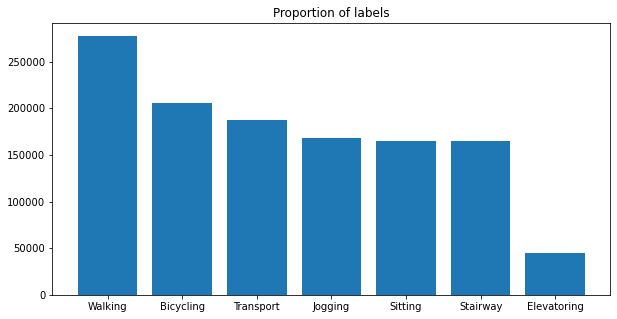

In [9]:
plt.figure(figsize=(10,5))
plt.bar(df["activity"].value_counts().index, df["activity"].value_counts().values)
plt.title("Proportion of labels")
plt.show()

### Encoding of classes 
Für das Modell werden die einzelnen Werte in nummerische Skalen transferiert. 

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df.activity)
set(encoded_labels)

{0, 1, 2, 3, 4, 5, 6}

### Feature - target split

In [11]:
df["activity"] = encoded_labels
y = df[["activity", "5s_index"]]
X = df.iloc[:, 3:]
FEATURE_COLUMNS = list(X.columns)[:-1]

In [12]:
sequences = list()
for series_id, group in tqdm(X.groupby("5s_index")):
    label = set(y[y["5s_index"]==series_id]["activity"])
    if len(label) != 1:
        continue
    sequence_features = group[FEATURE_COLUMNS]
    sequences.append((sequence_features, list(label)[0]))

print("Example sequence:\n\n", sequences[1252])

100%|███████████████████████████████████████████████████████████████████████████| 13487/13487 [00:28<00:00, 472.90it/s]

Example sequence:

 (              acc       mag       gyr       ori  kmh
1578294  0.485234  0.477736  0.596915  0.231539  0.0
1578295  0.462894  0.477561  0.611156  0.222006  0.0
1578296  0.463179  0.477856  0.612842  0.208042  0.0
1578297  0.459138  0.478223  0.620752  0.208209  0.0
1578298  0.474202  0.478451  0.622023  0.215178  0.0
...           ...       ...       ...       ...  ...
1580590  0.478525  0.480213  0.589665  0.720174  0.0
1580591  0.499386  0.480125  0.580141  0.721229  0.0
1580592  0.492821  0.480072  0.541657  0.726229  0.0
1580593  0.511931  0.480057  0.534250  0.736315  0.0
1580594  0.478688  0.480183  0.561441  0.752917  0.0

[90 rows x 5 columns], 4)


Oben sehen wir ein Beispiel wie ein Sample aussieht bevor es mit den anderen zu einem Datensatz zusammengefügt wird. Wir haben hier einerseits die Features in der Dimension (5 x 90) entsprechend der fünf Sensoren mit 90 Messwerten, als auch das encodiere Label (4), was der Aktivität Radfahren entspricht.

### Split sequences into train & test

In [13]:
train_seq, test_seq = train_test_split(sequences, test_size=0.2, random_state=42)

In [14]:
# save train sequences
if os.path.exists('./data/cnn_train_seq.pkl'):
    with open('./data/cnn_train_seq.pkl', 'rb') as f:
        train_seq = pickle.load(f)
else:
    with open('./data/cnn_train_seq.pkl', 'wb') as f:
        pickle.dump(train_seq, f)

# save test sequences      
if os.path.exists('./data/cnn_test_seq.pkl'):
    with open('./data/cnn_test_seq.pkl', 'rb') as f:
        test_seq = pickle.load(f)
else:  
    with open('./data/cnn_test_seq.pkl', 'wb') as f:
        pickle.dump(test_seq, f)

## Create ActivityDataset class

Hier wird aus den bereinigten Sensordaten eine Datensatz-Klasse generiert. Diese Struktur erlaubt es anschliessend einfach mittels PyTorch DataLoader Klasse Trainingsbatches zu erstellen und während dem Training zu laden.

In [15]:
from torch.utils.data import Dataset, DataLoader

class ActivityDataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.tensor(sequence.to_numpy(), dtype=torch.float), 
            label = torch.tensor(label).long())

In [16]:
batch_size = 64

train_dataloader = DataLoader(ActivityDataset(train_seq), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ActivityDataset(test_seq), batch_size=batch_size, shuffle=True)

### Load sample

Wir überprüfen nun den dataloader für das Trainings-Set.

In [17]:
example_batch = iter(train_dataloader)
batch = example_batch.next()
batch["sequence"].shape, batch["label"].shape

(torch.Size([64, 90, 5]), torch.Size([64]))

Wir sehen, dass der Dataloader funktioniert. Die Sequenzen haben die Dimension \[ *Batchsize*, *Sequenzlänge*, *Anzahl_Sensoren* \], die Labels haben die Dimension \[ *Batchsize* \]

## Define model classes

Da die von den Sensoren aufgezeichneten Daten Zeitreihendaten sind, macht es von der Intuition her Sinn auf diesen Zeitreihen nach Muster/Features zu suchen, welche für die Klassifikation relevant sind. Hierfür wollen wir CNN's verwenden und erstellen mit PyTorch mehrere eigene Modellklassen. Diese enthalten über den Dataloader  unsere Sensordaten Von der Struktur her sind am Anfang eine Kombination von mehreren eindimensionale Convolutionale  Layer [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) gefolgt von jeweils einem Max Pooling Layer [MaxPool1d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html) . Anschliessend folgen drei lineare Layer, von welchen der Letzte die Aktivierungen in der Dimension \[ Anzahl_Aktivitäten \] ausgibt.

Für die Aktivierungen der Layer verwenden wir die [Relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) Aktivierungsfunktion ausser beim letzten linearen Layer, wo wir im Training die Kostenfunktion mit über den [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) bestimmen um die Abweichungen der Vorhersage zu den korrekten Labels zu ermittelln und das Netz im training zu Optimieren.

Um Overfitting zu verhindern, wurden diverse Dropout Raten zwischen den einzelnen linearen Layern ausprobiert. Dropout setzt während dem Training eine Proportion der Aktivierungen im vorherigen Layer auf 0 wodurch diese nicht für die Vorhersage verwendet werden können. Entsprechend wird verhindert, dass das Netz in der Vorhersage durchgehend auf wenige sehr relevante Features konzentrieren kann und zwingen das Netz genereller zu lernen.

Für das Training wurden folgende Modelle und Hyperparameter ausprobiert:
- Anzahl Convolutionale Layer
- Anzahl Nodes pro Layer
- Variation der Learning Rate
- Dropout Rate
- Inklusion/exklusion von Batchnormalization

Das trainig wurde mittels Wandb geloggt: https://wandb.ai/simonluder/activity_tracker_cnn?workspace=user-simonluder

In [18]:
# hyperarameters
num_classes = 7


class CNN_2(nn.Module):
    def __init__(self, num_classes, kernel_size=10, pool_size=3, padding=0, conv1_channels = 10, conv2_channels=8, fc_linear_1=180, fc_linear_2=120, dropout=0):
        '''Convolutional Net class'''
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=1)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.fc1 = nn.Linear(in_features=conv2_channels*68, out_features=fc_linear_1)
        self.fc2 = nn.Linear(in_features=fc_linear_1, out_features=fc_linear_2)
        self.fc3 = nn.Linear(in_features=fc_linear_2, out_features=num_classes)
        self.conv2_channels = conv2_channels
    
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, x):
        '''
        Applies the forward pass
        Args:
            x (torch.tensor): input feature tensor
        Returns:
            x (torch.tensor): output tensor of size num_classes
        '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.conv2_channels*68) # flatten tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    
class CNN_2_bn(nn.Module):
    def __init__(self, num_classes, kernel_size=10, pool_size=3, padding=0, conv1_channels = 10, conv2_channels=8, fc_linear_1=180, fc_linear_2=120, dropout=0):
        '''Convolutional Net class'''
        super(CNN_2_bn, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding)
        self.conv1_bn=nn.BatchNorm1d(conv1_channels)
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=1)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv2_bn=nn.BatchNorm1d(conv2_channels)
        self.fc1 = nn.Linear(in_features=conv2_channels*68, out_features=fc_linear_1)
        self.fc1_bn = nn.BatchNorm1d(fc_linear_1)
        self.fc2 = nn.Linear(in_features=fc_linear_1, out_features=fc_linear_2)
        self.fc2_bn = nn.BatchNorm1d(fc_linear_2)
        self.fc3 = nn.Linear(in_features=fc_linear_2, out_features=num_classes)  
        self.conv2_channels = conv2_channels
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, x):
        '''
        Applies the forward pass
        Args:
            x (torch.tensor): input feature tensor
        Returns:
            x (torch.tensor): output tensor of size num_classes
        '''
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, self.conv2_channels*68) # flatten tensor
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class CNN_3(nn.Module):
    def __init__(self, num_classes, kernel_size=10, pool_size=3, padding=0, conv1_channels = 10, conv2_channels=8, conv3_channels=8, fc_linear_1=180, fc_linear_2=120, dropout=0):
        '''Convolutional Net class'''
        super(CNN_3, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=1)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv1d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding) 
        self.fc1 = nn.Linear(in_features=conv3_channels*57, out_features=fc_linear_1)
        self.fc2 = nn.Linear(in_features=fc_linear_1, out_features=fc_linear_2)
        self.fc3 = nn.Linear(in_features=fc_linear_2, out_features=num_classes)
        self.conv2_channels = conv2_channels
        self.conv3_channels = conv3_channels
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        '''
        Applies the forward pass
        Args:
            x (torch.tensor): input feature tensor
        Returns:
            x (torch.tensor): output tensor of size num_classes
        '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.conv3_channels*57) # flatten tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Define model trainer

In [19]:
import copy
class ModelTrainer:

    def __init__(self, model, train_loader, test_loader, num_epochs, criterion, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.logger = {
            "train":dict(),
            "test":dict()
        }
        self.best_log = dict()
        self.best_model = None
        
        
    def wandb_log(self, log_dict, e):
        '''
        Logs all parameters in log dict to weights and biases
        Args:
            log_dict (dict): dict with log values
            e (int): epoch identifier
        '''
        wandb.log(log_dict, step=e)
        

    def calculate_accuracy(self, pred, true):
        '''
        Calculates the accuracy for the prediction
        Args: 
            pred: predicted labels
            true: true labels
        Returns:
            accuracy as float
        '''
        return (pred.argmax(1) == true).type(torch.float).sum().item()


    def get_best_model(self):
        ''''
        Returns the best model
        '''
        return self.best_model
    

    def train_loop(self, dataloader, verbose):
        '''
        Loop for a sigle training epoch.
        Args:
            dataloader: pytorch dataloader
        '''
        self.model.train()
        epoch_accuracy = 0
        epoch_loss = 0
        epoch_f1 = 0
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)

        for i, batch in enumerate(dataloader):
            sequences = torch.transpose(batch["sequence"], 1, 2).to(device)
            labels = batch["label"].to(device)

            # Forward propagation
            pred = self.model(sequences)
            loss = self.criterion(pred, labels)

            # Backward propagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # calculate metrics
            epoch_loss += loss.item()
            epoch_accuracy += self.calculate_accuracy(pred, labels)
            epoch_f1 += f1_score(labels.detach().cpu().numpy(), np.argmax(pred.detach().cpu().numpy(), axis=1), average="macro")

        epoch_loss /= num_batches
        epoch_accuracy /= num_samples
        epoch_f1 /= num_batches
        if verbose:
            print(f"train loss:{epoch_loss}, train f1-score:{epoch_f1}, train accuracy:{epoch_accuracy}")
        return {"train loss":epoch_loss, "train f1-score":epoch_f1, "train accuracy":epoch_accuracy}


    def test_loop(self, dataloader, label="train"):
        self.model.eval()
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_f1 = 0
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                sequences = torch.transpose(batch["sequence"], 1, 2).to(device)
                labels = batch["label"].to(device)

                # Forward propagation
                pred = self.model(sequences)

                # calculate metrics
                epoch_loss += self.criterion(pred, labels).item()
                epoch_accuracy += self.calculate_accuracy(pred, labels)
                epoch_f1 += f1_score(labels.detach().cpu().numpy(), np.argmax(pred.detach().cpu().numpy(), axis=1), average="macro")
               
        epoch_loss /= num_batches
        epoch_accuracy /= num_samples
        epoch_f1 /= num_batches
        return {"{} loss".format(label): epoch_loss, "{} f1-score".format(label): epoch_f1, "{} accuracy".format(label): epoch_accuracy}


    def train(self, verbose=False, include_test_scores=False, wb=False, best_by="test f1-score"):
        
        # calculate initial model preformance for train_set
        self.logger["train"][0] = self.test_loop(self.train_loader, label="train")
        if wb:
            self.wandb_log(self.logger["train"][0], 0)

        # calculate initial model preformance for test_set
        if include_test_scores:
            self.logger["test"][0] = self.test_loop(self.test_loader, label="test")
            if wb:
                self.wandb_log(self.logger["test"][0], 0)
            # save init as best model
            self.best_log = self.logger["test"][0]
            self.best_model = copy.deepcopy(self.model)
            
        # run model train epochs
        for e in range(self.num_epochs):
            if verbose:
                print(f"Epoch: {e+1} ------------------------------")
            
            # model train step
            self.logger["train"][e+1] = self.train_loop(self.train_loader, verbose)
            if wb:
                self.wandb_log(self.logger["train"][e+1], e+1)

            # calculate model preformance
            if include_test_scores:
                self.logger["test"][e+1] = self.test_loop(self.test_loader, label="test")
                if wb:
                    self.wandb_log(self.logger["test"][e+1], e+1)
                # secure model with best test score
                if self.best_log[best_by] < self.logger["test"][e+1][best_by]:
                    self.best_log = self.logger["test"][e+1]
                    self.best_model = copy.deepcopy(self.model)
        return self


## Train models with wandb

In [20]:
wandb.login()

True

In [21]:
run_sweeps = False
num_epochs = 1000               # epochs
count = 3                       # number of runs to execute
path="./top_model"              # path to save models
min_f1 = 0.70                   # minimal test f1 to save the model


sweep_configuration = {
    "name": "cnn testsweep",
    "metric": {"name": "test f1-score", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.001, 0.002, 0.0005]
        },
         "batch_size": {
            "value": batch_size
        },
        "l2_weight_decay": {
            "value": 0
        },
        "dropout_rate": {
            "values": [0.05, 0.1, 0.2, 0.3, 0.4]
        },
        "conv1_channels": {
            "values":[256,]
        },
        "conv2_channels": {
            "values":[256,]
        },
        "fc_linear_1": {
            "value": 128
        },
        "fc_linear_2": {
            "value": 64
        }
    }
}


def save_model(path, model, name):
        '''
        Saves the model as state dict.
        Args:
            path (str): path where to save the model
        '''
        filename = "/{}.pt".format(name)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)


def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = CNN_2_bn(
            num_classes=num_classes,
            conv1_channels=config["conv1_channels"],
            conv2_channels=config["conv2_channels"],
            fc_linear_1=config["fc_linear_1"],
            fc_linear_2=config["fc_linear_2"],
            dropout=config["dropout_rate"]
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_dataloader, 
            test_loader=test_dataloader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True, wb=True)

        # save model if minimal f1-score is reached
        if trainer.best_log["test f1-score"] >= min_f1:
            save_model(path="models/saved_models", model=trainer.best_model, name=wandb.run.name)

       
if run_sweeps:
    sweep_id = wandb.sweep(sweep_configuration, project="activity_tracker_cnn", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=count)

## Evaluation

Anschliessend werden die drei besten Modelle aus dem Training genauer evaluiert.

In [22]:
path ="models/top_models/"
model_files = ["2022-06-04-14-36-07.pt", "2022-06-04-13-25-27.pt", "2022-06-04-14-00-54.pt"]


def predict(model, dataloader):
    p, l = [], []
    for batch in iter(dataloader):
        seq = torch.transpose(batch["sequence"], 1, 2).to(device)
        labels = batch["label"].to(device)
        p.extend((model(seq).argmax(axis=1).cpu()).numpy())
        l.extend(labels.cpu().numpy())
    return p, l

def load_model(path, file):
        model = torch.load(path + file, map_location=device)
        model.eval()
        return model

def plot_confusion_matrix(pred, labels):
    '''Visualizes the confusion matrix from an input of predicted and true labels'''
    label_encoder.inverse_transform(pred)
    label_encoder.inverse_transform(labels)
    plt.figure(figsize=(8,7))
    sns.heatmap(
        confusion_matrix(label_encoder.inverse_transform(pred), label_encoder.inverse_transform(labels)), 
        annot=True, 
        fmt='d',
        xticklabels=label_encoder.inverse_transform(range(0,7)), 
        yticklabels=label_encoder.inverse_transform(range(0,7)))
    plt.show()

test_labels = dict()
test_preds = dict()

#load models
model_dict = dict()
for i, file in enumerate(model_files):
    model_dict[file] = load_model(path, file)
    test_labels[file] = []
    test_preds[file] = []

for batch in iter(test_dataloader):
    seq = torch.transpose(batch["sequence"], 1, 2).to(device)
    labels = batch["label"].to(device)

    for m in model_dict:
        test_preds[m].extend((model_dict[m](seq).argmax(axis=1).cpu()).numpy())
        test_labels[m].extend(labels.cpu().numpy())

In [23]:
for model_name in model_files:
    print("\nModel:", model_name)
    print("accuracy-score:", np.sum(np.array(test_preds[model_name]) == np.array(test_labels[model_name])) / len(test_dataloader.dataset))
    print("f1-score macro:", f1_score(test_labels[model_name], test_preds[model_name], average="macro"))
    print("f1-score weighted:", f1_score(test_labels[model_name], test_preds[model_name], average="weighted"))


Model: 2022-06-04-14-36-07.pt
accuracy-score: 0.9301717699775952
f1-score macro: 0.9123651566244427
f1-score weighted: 0.9305431245029477

Model: 2022-06-04-13-25-27.pt
accuracy-score: 0.9256908140403286
f1-score macro: 0.9103030677172811
f1-score weighted: 0.9256989502359376

Model: 2022-06-04-14-00-54.pt
accuracy-score: 0.9174757281553398
f1-score macro: 0.9010883067817171
f1-score weighted: 0.9171218275085691


Wir errechen mit unseren besten drei Modellen jeweils eine Accuracy als auch F1 Score von über 0.9 was zeigt, dass die Modelle die Aktivitäten generell gut erkennen können. Das besste Modell konnte sogar eine Accuracy von 0.93 erreichen. Das zeig uns, dass ein CNN generell gut für die Klassifikation der Sensordaten geeignet ist.

Model: 2022-06-04-14-36-07.pt


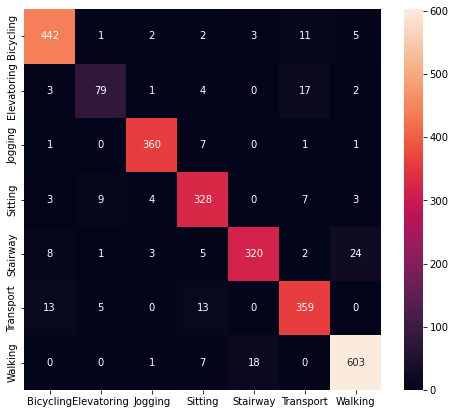

Model: 2022-06-04-13-25-27.pt


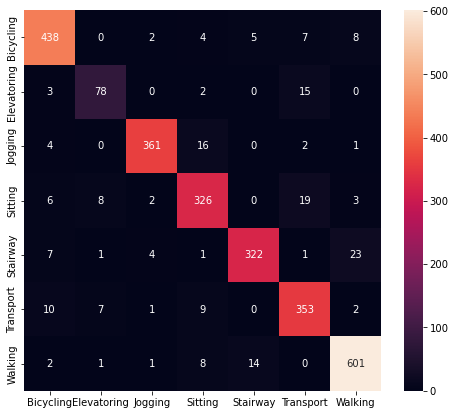

Model: 2022-06-04-14-00-54.pt


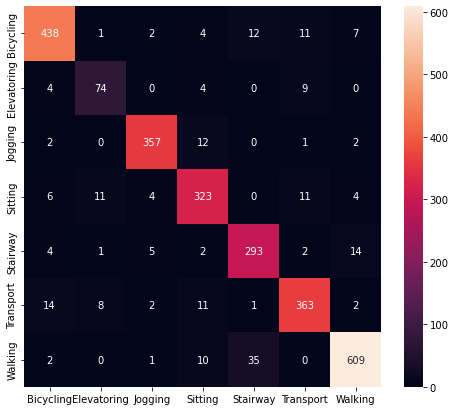

In [24]:
for model_name in model_files:
    print("Model:", model_name)
    plot_confusion_matrix(test_preds[model_name], test_labels[model_name])

Wir sehen oben nun noch die Konfusion-Matrizen der Modelle auf dem Testset. Es ist erkennbar, dass die Modelle die sieben Aktivitäten generell gut klassifizieren. Die Fehler, welche erkennbar sind, machen aufgrund dessen wie die Daten erhoben wurden sinn. So sehen wir zum Beispiel mehr falsche Klassifikationen zwischen "sitting" und "transport", was Sinn macht, da die Datenerhebung nicht unterbrochen wurde, wenn ein Bus oder Tram an einer Station stillstand. Auch überdurchschnittlich oft verwechselt wurde "walking" mit "stairways", was dadurch erklärbar sein könnte, dass zwischen den Etagen im Treppenhaus auch gerade Strecken begangen wurden.

### Code setup for predicting in app

Diese Sektion dient als Textstruktur für die EInbindung eines Modells in die App.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

#hyperparameters
window_size = 90
stride = 5

# create 2d array from dataframe
arr_2d = df[["acc", "mag", "gyr", "ori", "kmh"]].values[:180] #example if 180 datapoints ~ 10 sec

# slide over array to create moving windows
arr_3d = np.lib.stride_tricks.sliding_window_view(arr_2d, window_size, 0)[::stride]

# create tensors
tensors = torch.tensor(arr_3d).to(device)
tensors = tensors.float()

print("Array shape before stride:", np.shape(arr_2d))
print("Array shape after stride:", np.shape(arr_3d))
print("Resulting tensor dimension:", np.shape(tensors))

Array shape before stride: (180, 5)
Array shape after stride: (19, 5, 90)
Resulting tensor dimension: torch.Size([19, 5, 90])


In [27]:
def normalize_scales(df):
    '''
    Standardizes the sensor scales with the mean and standard deviation from the testset        
    '''
    df = df.copy()
    x = df[["acc", "mag", "gyr", "ori", "kmh"]]
    scale_max = [4.42877550e+01, 8.81122530e+03, 1.16565825e+02, 5.99909750e+00, 1.18619879e+02]
    scale_min = [1.87147230e+01, 3.29054710e+03, 5.16912100e+01, 2.27530129e+00, 0.00000000e+00]
    for i, col in enumerate(x.columns):
        x[col] = (x[col] - scale_min[i]) / (scale_max[i] - scale_min[i])
    return x

def transform_to_tensors(df, window_size = 90, stride = 10):
    '''
    Transforms the dataframe into a 3d tensor of shape (X, 5, 90)
    Args:
        df (pandas DataFrame): dataframe with sensordata
    Returns:
        tensors (torch tensor)
    '''
    # create array
    arr_2d = df[["acc", "mag", "gyr", "ori", "kmh"]].values 

    # slide over array to create moving windows
    arr_3d = np.lib.stride_tricks.sliding_window_view(arr_2d, window_size, 0)[::stride]

    # create tensors
    tensors = torch.tensor(arr_3d).to(device)
    tensors = tensors.float()
    return tensors


def predict_with_cnn_1(tensors, model, num_classes=7):
    '''
    Predicts an activity using a cnn model from a tensor of sensordata "acc", "mag", "gyr", "ori", "kmh"
    Args: 
        tensors (torch tensor): the sensordaa as 3d tensor of format (X, 5, 90)
        model_url (str): the url where the model is stored
        num_classes (int): 4 or 7 depeding on the number of classes to predict
    Returns:
        String prediction
    '''
    itos_7= {
        0:"Bicycling",
        1:"Elevatoring",
        2:"Jogging",
        3:"Sitting",
        4:"Stairway",
        5:"Transport",
        6:"Walking"}

    # set model to eval mode
    model.eval()
    # predict
    with torch.no_grad():
        output = model(tensors)
        pred=torch.max(output, 1)
        labels = pred.indices
        labels_numpy = labels.cpu().numpy()
        counts = np.bincount(labels_numpy)
        if num_classes == 7:
            return itos_7[np.argmax(counts)]


model = torch.load("models/top_models/2022-05-07-01-28-13.pt", map_location=device)
df = pd.read_csv("./data/deep_models.csv")
df = normalize_scales(df[0:100])
tensors = transform_to_tensors(df)
predict_with_cnn_1(tensors, model = model, num_classes=7)

'Transport'